In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = 'Dataset/mental_health_dataset.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully")
except FileNotFoundError:
    print(f"Error: File was not found")
    exit()

Dataset Loaded Successfully


In [4]:
df_cleaned = df.copy()

## Dealing with age null value

if df_cleaned['age'].isnull().any():
    median_age = df_cleaned['age'].median()
    df_cleaned['age'].fillna(median_age, inplace=True)
    print(f"Filled missing age values with median: {median_age}")

Filled missing age values with median: 67.0


/var/folders/tq/ccq973m935z0vfy3hz1hmk680000gn/T/ipykernel_2135/1881539742.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['age'].fillna(median_age, inplace=True)


In [5]:
## Dealing with condition type missing values

if df_cleaned['condition_type'].isnull().any():
    mode_condition_type = df_cleaned['condition_type'].mode()[0]
    df_cleaned['condition_type'].fillna(mode_condition_type, inplace=True)
    print(f"filled missing condition_type values with mode: {mode_condition_type}")

filled missing condition_type values with mode: Breast


/var/folders/tq/ccq973m935z0vfy3hz1hmk680000gn/T/ipykernel_2135/3621732522.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['condition_type'].fillna(mode_condition_type, inplace=True)


In [6]:
## Dealing with bdi_ii_baseline missing values

if df_cleaned['bdi_ii_baseline'].isnull().any():
    median_baseline = df_cleaned['bdi_ii_baseline'].median()
    df_cleaned['bdi_ii_baseline'].fillna(median_baseline, inplace=True)
    print(f"Filled missing values with the median values: {median_baseline}")

Filled missing values with the median values: 10.0


/var/folders/tq/ccq973m935z0vfy3hz1hmk680000gn/T/ipykernel_2135/2846433286.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['bdi_ii_baseline'].fillna(median_baseline, inplace=True)


## Feature Engineering

Creating a new column session_completion_rate so that it can make an impact.

In [7]:
df_cleaned['session_completion_rate'] = df_cleaned['mindfulness_therapies_completed'] / df_cleaned['mindfulness_therapies_started']

# Handle cases where therapies_started is 0 to avoid division by zero errors.
df_cleaned['session_completion_rate'].fillna(0, inplace=True)
print("Created 'session_completion_rate' feature.")

Created 'session_completion_rate' feature.


/var/folders/tq/ccq973m935z0vfy3hz1hmk680000gn/T/ipykernel_2135/2711946710.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['session_completion_rate'].fillna(0, inplace=True)


In [8]:
cat_cols = ["sex", "condition", "condition_type", "hospital_center_id"]
for c in cat_cols:
    df_cleaned[c] = df_cleaned[c].astype("category")

# Previewing unique values (to sanity check)
for c in cat_cols:
    print(f"\n{c} -> {df_cleaned[c].nunique()} unique values")
    print(df_cleaned[c].cat.categories.tolist()[:10])  # show up to first 10 categories


sex -> 2 unique values
['female', 'male']

condition -> 4 unique values
['Acute coronary syndrome', 'Cancer', 'Lower-limb amputation', 'Renal insufficiency']

condition_type -> 7 unique values
['Breast', 'Dialysis', 'No prosthesis', 'Percutaneous coronary intervention', 'Predialysis', 'Prostate', 'Revascularization']

hospital_center_id -> 3 unique values
[1, 2, 3]


In [9]:
df_encoded = df_cleaned.copy()

In [10]:
sex_mapping = {'female': 0, 'male': 1}
df_encoded['sex'] = df_encoded['sex'].map(sex_mapping)
print("Applied Label Encoding to 'sex' column.")

Applied Label Encoding to 'sex' column.


In [11]:
cat_cols1 = ['condition', 'condition_type', 'hospital_center_id']
df_encoded = pd.get_dummies(df_encoded, columns=cat_cols1, prefix=cat_cols1, dtype=int)
print("Applied One-Hot Encoding to 'condition', 'condition_type', and 'hospital_center_id'.")

Applied One-Hot Encoding to 'condition', 'condition_type', and 'hospital_center_id'.


## Model Training

In [12]:
import shap

def run_shap_analysis(model, X_test, model_name, target_name):
    """
    Performs SHAP analysis on the best model to explain feature importance.
    """
    print(f"\n--- Running SHAP Analysis for {model_name} on {target_name} ---")
   
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
   
    # Generate the SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP Feature Importance for {target_name}\n(Model: {model_name})", fontsize=16)
    plt.tight_layout()
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
import numpy as np
def create_features(df_to_feature):
    df_to_feature["delta_12w"] = df_to_feature["bdi_ii_baseline"] - df_to_feature["bdi_ii_after_intervention_12w"]
    df_to_feature["delta_24w"] = df_to_feature["bdi_ii_baseline"] - df_to_feature["bdi_ii_follow_up_24w"]
    df_to_feature["pct_improve_12w"] = np.where(df_to_feature["bdi_ii_baseline"] > 0, 100 * df_to_feature["delta_12w"] / df_to_feature["bdi_ii_baseline"], np.nan)
    df_to_feature["pct_improve_24w"] = np.where(df_to_feature["bdi_ii_baseline"] > 0, 100 * df_to_feature["delta_24w"] / df_to_feature["bdi_ii_baseline"], np.nan)
    df_to_feature["completion_rate"] = np.where(df_to_feature["mindfulness_therapies_started"] > 0, df_to_feature["mindfulness_therapies_completed"] / df_to_feature["mindfulness_therapies_started"], 0)
    df_to_feature['completion_rate'].fillna(0, inplace=True)
    return df_to_feature

In [15]:
## STOCHASTIC (MODEL-BASED + NOISE) IMPUTATION

def impute_with_noise(data, target_column):
    """
    Trains a model on known targets, predicts missing targets, adds random noise,
    and then fills the missing values.
    """
    print(f"\n--- Running Stochastic Imputation for: {target_column} ---")
   
    data_with_target = data[data[target_column].notna()]
    data_to_impute = data[data[target_column].isna()]


    if len(data_to_impute) == 0:
        print("No missing values to impute.")
        return data
       
    y_helper = data_with_target[target_column]
    cols_to_exclude = [
        'bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w',
        'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w'
    ]
    X_helper = data_with_target.drop(columns=[col for col in cols_to_exclude if col in data_with_target.columns])
    X_to_impute = data_to_impute.drop(columns=[col for col in cols_to_exclude if col in data_to_impute.columns])

    numerical_cols = X_helper.select_dtypes(include=np.number).columns
    cols_to_scale = [col for col in numerical_cols if len(X_helper[col].unique()) > 2]
    
    scaler = StandardScaler()
    X_helper[cols_to_scale] = scaler.fit_transform(X_helper[cols_to_scale])
    X_to_impute[cols_to_scale] = scaler.transform(X_to_impute[cols_to_scale])


    helper_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    helper_model.fit(X_helper, y_helper)
   
    predicted_values = helper_model.predict(X_to_impute)
   
    # --- NEW: ADDING NOISE TO THE PREDICTIONS ---
    # Create a random noise factor between 0.8 and 1.2 for each prediction
    noise_factor = np.random.uniform(0.8, 1.2, size=len(predicted_values))
    randomized_values = predicted_values * noise_factor
   
    # Ensure scores do not become negative after randomization
    randomized_values = np.maximum(0, randomized_values)
   
    imputed_data = data.copy()
    imputed_data.loc[imputed_data[target_column].isna(), target_column] = randomized_values
   
    print(f"Successfully imputed {len(data_to_impute)} missing values with noise.")
    return imputed_data


# --- Run the imputation process for both target variables ---
df_imputed_noisy = impute_with_noise(df_encoded, 'bdi_ii_after_intervention_12w')
df_imputed_noisy = impute_with_noise(df_imputed_noisy, 'bdi_ii_follow_up_24w')


# --- Recalculate features with the new imputed data ---
df_final = create_features(df_imputed_noisy)
print("\n--- Imputation Complete and Features Recalculated ---")


--- Running Stochastic Imputation for: bdi_ii_after_intervention_12w ---
Successfully imputed 43 missing values with noise.

--- Running Stochastic Imputation for: bdi_ii_follow_up_24w ---
Successfully imputed 44 missing values with noise.

--- Imputation Complete and Features Recalculated ---


/var/folders/tq/ccq973m935z0vfy3hz1hmk680000gn/T/ipykernel_2135/1951034295.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_to_feature['completion_rate'].fillna(0, inplace=True)


In [16]:
def run_interpretation(model, model_name, X_data, target_name):
    """
    Generates and saves a feature importance plot for the given model.
    Handles both linear (coefficients) and tree-based (SHAP) models.
    """
    plt.figure(figsize=(10, 8))


    if model_name == "Ridge Regression":
        # For linear models, we plot the coefficients directly
        try:
            coefficients = pd.Series(model.coef_, index=X_data.columns)
            # Plot top 20 most important features
            sorted_coeffs = coefficients.abs().sort_values(ascending=False).head(20)
            coefficients[sorted_coeffs.index].sort_values().plot(kind='barh')
            plt.title(f'Feature Importance for {target_name}\n(Model: Ridge Regression Coefficients)')
           
        except Exception as e:
            print(f"Could not plot coefficients for Ridge Regression: {e}")
            return
           
    else: # For tree-based models, use SHAP
        try:
            print(f"  > Calculating SHAP values for {model_name}...")
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data)
           
            shap.summary_plot(shap_values, X_data, show=False, plot_size=None)
            plt.title(f'SHAP Feature Importance for {target_name}\n(Model: {model_name})')


        except Exception as e:
            print(f"Could not generate SHAP plot for {model_name}: {e}")
            return


    # Final plot adjustments and saving
    plt.tight_layout()
    # Sanitize filename
    safe_target_name = target_name.replace(' ', '_').replace('/', '_')
    safe_model_name = model_name.replace(' ', '_')
    plt.savefig(f'figures/Importance_{safe_target_name}_{safe_model_name}.png', dpi=300)
    plt.show()

In [17]:
from sklearn.model_selection import train_test_split

def final_train_and_evaluate(data, target_column):
    """
    This function takes the fully imputed data and a target column name,
    then trains and evaluates a suite of regression models.
    """
    print(f"\n{'='*30}")
    print(f"  FINAL MODELING FOR: {target_column}")
    print(f"{'='*30}\n")
   
    # Define features (X) and target (y)
    y = data[target_column]
    cols_to_exclude = [
        'bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w',
        'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w'
    ]
    X = data.drop(columns=[col for col in cols_to_exclude if col in data.columns])


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.")
   
    models = {
        "Ridge Regression": Ridge(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        "XGBoost": XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),  # silence xgboost
        "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),  # silence LightGBM
        "CatBoost": CatBoostRegressor(random_state=42, verbose=0) 
    }
   
    results = []
   
    best_model = None
    best_model_name = ""
    best_rmse = float('inf')

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append({"Model": name, "RMSE": rmse, "R-squared": r2})
       
        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_model_name = name
           
    results_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True).reset_index(drop=True)
    print("\n--- Model Performance Results ---")
    print(results_df)
    print(f"\nBEST MODEL: {best_model_name} with RMSE: {best_rmse:.4f}")

    print(f"--- Generating Feature Importance for Best Model ({best_model_name}) ---")
    run_interpretation(best_model, best_model_name, X_test, target_column)

In [18]:
df_final["sex"] = df_encoded["sex"].astype(int)


  FINAL MODELING FOR: bdi_ii_after_intervention_12w

Training on 168 samples, testing on 42 samples.

--- Model Performance Results ---
              Model      RMSE  R-squared
0  Ridge Regression  5.358044   0.462795
1          LightGBM  5.533168   0.427105
2     Random Forest  5.929489   0.342097
3          CatBoost  6.087361   0.306597
4           XGBoost  6.103222   0.302979

BEST MODEL: Ridge Regression with RMSE: 5.3580
--- Generating Feature Importance for Best Model (Ridge Regression) ---


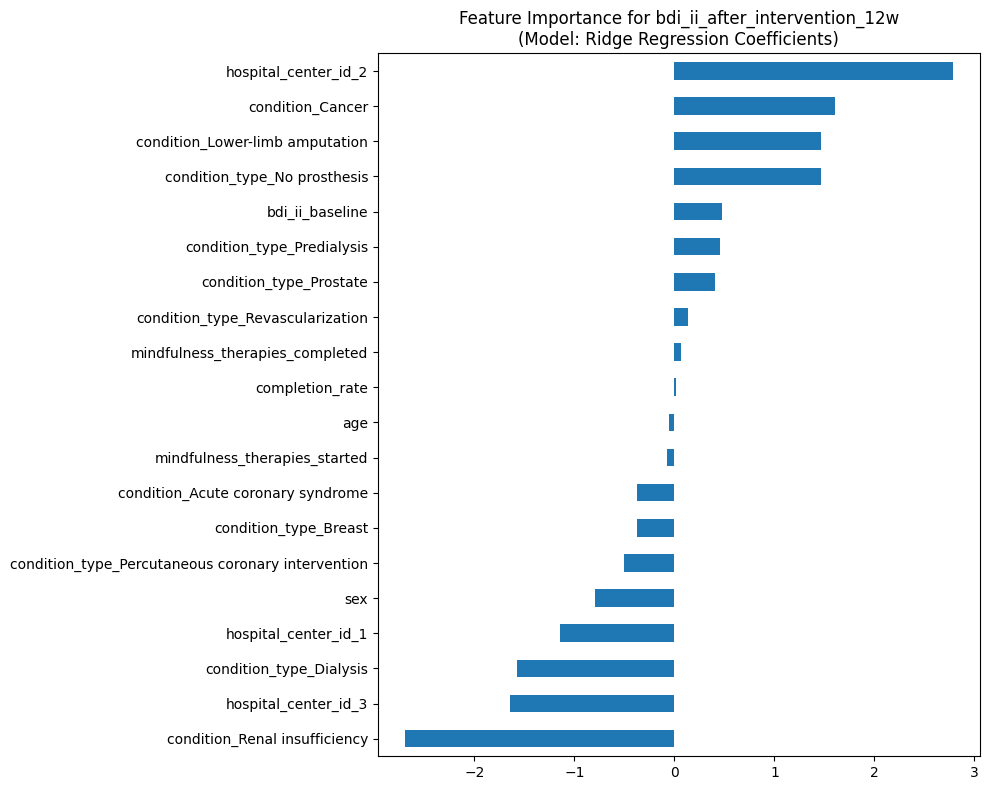

In [19]:
final_train_and_evaluate(df_final, 'bdi_ii_after_intervention_12w')


  FINAL MODELING FOR: bdi_ii_follow_up_24w

Training on 168 samples, testing on 42 samples.

--- Model Performance Results ---
              Model      RMSE  R-squared
0          LightGBM  5.092612   0.525633
1          CatBoost  5.652728   0.415547
2           XGBoost  5.667308   0.412529
3     Random Forest  5.694063   0.406969
4  Ridge Regression  6.081931   0.323425

BEST MODEL: LightGBM with RMSE: 5.0926
--- Generating Feature Importance for Best Model (LightGBM) ---
  > Calculating SHAP values for LightGBM...


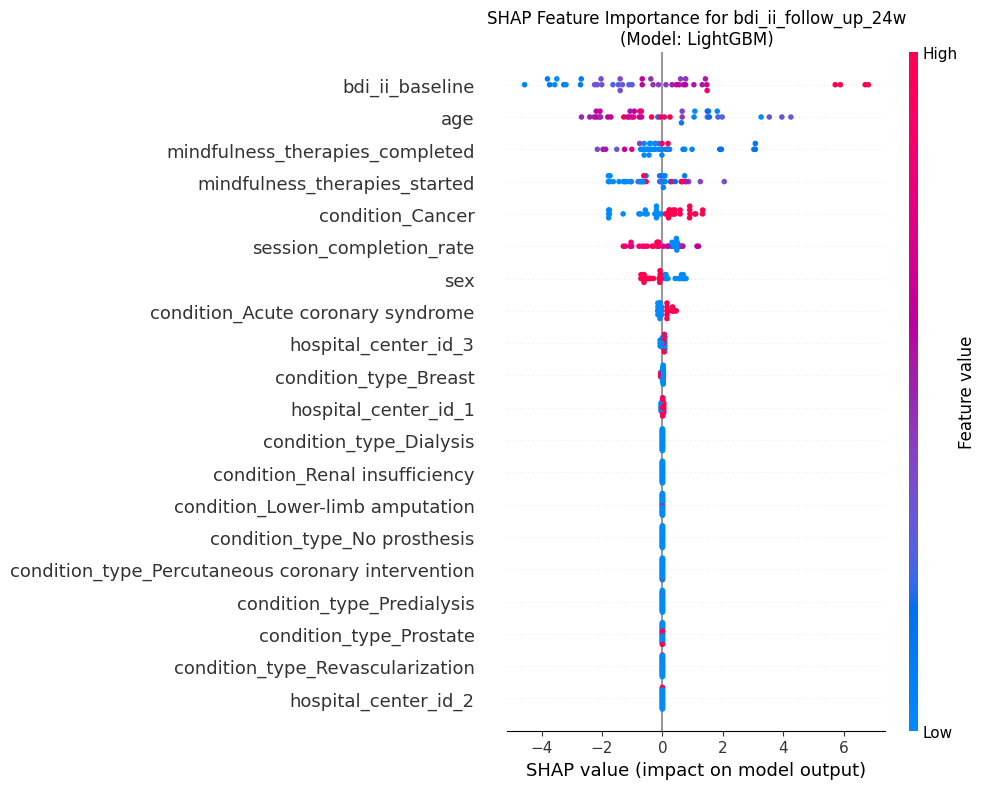

In [20]:
final_train_and_evaluate(df_final, 'bdi_ii_follow_up_24w')